# Generate and edit the AudioSet ontology

Using [Owlready2](https://owlready2.readthedocs.io/en/latest/index.html) package

First define the Notebook parameters for [papermill](https://papermill.readthedocs.io/en/latest/usage-parameterize.html)

In [1]:
# Papermill parameters
output_format = 'rdfxml'

Import the library and define the local `ontologies` folder. If an URL is given, first searches for a local copy of the OWL file and, if not found, tries to download it from the Internet.

In [2]:
from owlready2 import *

if output_format == 'ntriples':
    output_extension = 'nt'
else:
    output_extension = 'rdf'

onto_path.append("/notebooks/ontologies")

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


## Create and load ontologies

Create the AudioSet ontology and load the Pizza ontology from the Internet (for example purpose)

In [3]:
audioset_onto = get_ontology("https://w3id.org/audioset/ontology")

pizza_onto = get_ontology("http://www.lesfleursdunormal.fr/static/_downloads/pizza_onto.owl").load()

## Add classes and properties

See [Owlready2 documentation](https://owlready2.readthedocs.io/en/latest/index.html) for:
* [Properties](https://owlready2.readthedocs.io/en/latest/properties.html)
* [Classes](https://owlready2.readthedocs.io/en/latest/class.html)

In [4]:
with audioset_onto:
    class HumanSounds(Thing):
        pass
    class HumanVoice(HumanSounds):
        pass
    class Accent(Thing):
        pass
    class has_accent(ObjectProperty):
        domain    = [HumanVoice]
        range     = [Accent]
    class description(ObjectProperty):
        range     = [str]

## Explore an ontology

List an ontology classes and properties

In [5]:
print(audioset_onto.HumanVoice.iri)
print(list(audioset_onto.classes()))
print(list(audioset_onto.object_properties()))

https://w3id.org/audioset/ontology#HumanVoice
[ontology.HumanSounds, ontology.HumanVoice, ontology.Accent]
[ontology.has_accent, ontology.description]


## Add metadata to the ontology

In [6]:
audioset_onto.metadata.comment.append("OWL Ontology for the AudioSet dataset from Google.")

## Save the ontology file

Ontology files saved in the `ontologies` folder. 

2 formats available, defined in the papermill parameters (at the start of the notebook or in the `papermill-config.json` file):
* `rdfxml`
* `ntriples`

In [7]:
audioset_onto.save(file = "ontologies/audioset." + output_extension, format = output_format)

## Visualize as graph using networkx

Use rdflib and networkx to load the data in the graph and display it

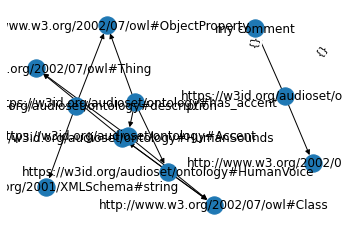

In [8]:
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt

url= 'https://raw.githubusercontent.com/MaastrichtU-IDS/ontology-editor-audioset/master/ontologies/audioset.rdf'

g = rdflib.Graph()
result = g.parse(url, format='xml')
# result = g.parse(url)

G = rdflib_to_networkx_multidigraph(result)

# Plot Networkx instance of RDF Graph
pos = nx.spring_layout(G, scale=3)
edge_labels = nx.get_edge_attributes(G, 'r')
nx.draw_networkx_edge_labels(G, pos, labels=edge_labels)
nx.draw(G, with_labels=True)

## Use Ontospy to analyze the ontology

In [9]:
import ontospy
audioset_spy = ontospy.Ontospy("https://raw.githubusercontent.com/MaastrichtU-IDS/ontology-editor-audioset/master/ontologies/audioset.rdf", verbose=True)

Reading: <https://raw.githubusercontent.com/MaastrichtU-IDS/ontology-editor-audioset/master/ontologies/audioset.rdf>
.. trying rdf serialization: <xml>
..... success!
----------
Loaded 13 triples.
----------
RDF sources loaded successfully: 1 of 1.
..... 'https://raw.githubusercontent.com/MaastrichtU-IDS/ontology-editor-audioset/master/ontologies/audioset.rdf'
----------


Scanning entities...
----------
Ontologies.........: 1
Classes............: 3
Properties.........: 2
..annotation.......: 0
..datatype.........: 0
..object...........: 2
Concepts (SKOS)....: 0
Shapes (SHACL).....: 0
----------


In [10]:
audioset_spy.printClassTree()
audioset_spy.toplayer_classes

ontology:Accent
ontology:HumanSounds
----ontology:HumanVoice


[<Class *https://w3id.org/audioset/ontology#Accent*>,
 <Class *https://w3id.org/audioset/ontology#HumanSounds*>]

## Generate docs

Use the commandline:

```bash
os.system('ontospy gendocs -o docs https://raw.githubusercontent.com/MaastrichtU-IDS/ontology-editor-audioset/master/ontologies/audioset.rdf')
```

In [11]:
# from ontospy.ontodocs.viz.viz_html_single import *

# v = HTMLVisualizer(audioset_spy) # => instantiate the visualization object
# v.build("/notebooks/docs") # => render visualization. You can pass an 'output_path' parameter too
# v.preview() # => open in browser

Done.
=> file:///notebooks/docs/index.html


256